# Evaluating cloud dilation options for Landsat Fmask <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)



## Getting started

### Load packages
Import Python packages used for the analysis.


In [1]:
import datacube
from datacube.utils.masking import make_mask
from odc.algo import mask_cleanup, erase_bad, enum_to_bool, to_f32
from datacube.utils.geometry import CRS, Geometry, GeoBox
from odc.algo import to_f32, xr_geomedian, int_geomedian
from dea_tools.plotting import rgb
from dea_tools.datahandling import load_ard

import os
import sys
import fiona
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(1, "../Tools/")
from dea_tools.dask import create_local_dask_cluster

# Launch Dask cluster
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39917,Workers: 1
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:45021,Total threads: 62
Dashboard: /user/james.miller@ga.gov.au/proxy/44569/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:37723,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Cloud_dilation-analysis-3")

### Assumptions

In [12]:
start_buffering = 0
end_buffering = 20
bands = [
    "nbart_blue",
    "nbart_red",
    "nbart_green",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
    "oa_fmask",
]
products = [
    "ga_ls5t_ard_3",
    "ga_ls7e_ard_3",
    "ga_ls8c_ard_3",
#    "ga_ls9c_ard_3",
]
maturity = "final"
time_period = None  # ("1990", "1995")   # ('2015-01-01', '2015-05-01')  # # Set to none for entire sensor record, otherwise:  # ('2015-01-01', '2015-05-01')
#time_period = ('2015-01-01', '2016-01-01')

# full validation path-rows - most have been commented out for faster testing
path_row_list = [
#    "113082",
#    "111077",
#    "108083",
#    "108079",
#    "105069",
#    "103073",
#    "099079",
#    "098077",
     "098071",
#    "097081",
#    "095082",
#    "094085",
#    "093086",
#    "096072",
#    "091089",
#    "090086",
#    "090084",
#    "090085",
#    "091079",
#    "090084",
#    "089084",
#    "090079",
#    "089079",
]

geomedian_threads = 30

In [5]:
def landsat_scene_poly(path_row, radius=None):
    """
    Get geometry for a given landsat path row

    Parameters
    ----------
    path_row : string
        Path row to search for
    radius : int, optional
        If provided, the centroid of the path row geom will be buffered
        by `radius` metres to provide a smaller geometry located within
        the path row, reducing memory and processing.

    Returns
    -------
    geometry : geometry
        geopolygon for given path row
    """

    # Path to Landsat file on S3
    landsat_shape = "https://data.dea.ga.gov.au/derivative/ga_ls_path_row_grid.geojson"

    # Select feature
    with fiona.open(landsat_shape) as all_shapes:
        for s in all_shapes:
            # landsat pathrows dont include 0 in front hence convert path-row to int to drop 0
            if s["properties"].get("PR") == int(path_row):
                # Extract geom
                geom = Geometry(s["geometry"], crs=CRS("EPSG:4326"))

                # Buffer centroid by X and return geom
                if radius is not None:
                    geom = geom.to_crs("EPSG:3577").centroid.buffer(radius)

                return geom

### Select spatiotemporal query

In [6]:
# for full path-row geopolygon
def define_query_params(path_row, time_period, maturity, radius=None):
    """
    Create query params for odc load

    Parameters
    ----------
    path_row : string
        Path row to search for
    time_period : list
        Time range
    maturity : string
        The dataset maturity level to include in the analysis
    radius : int, optional
        If provided, the centroid of the path row geom will be buffered
        by `radius` metres to provide a smaller geometry located within
        the path row, reducing memory and processing.

    Returns
    -------
    query_params : dictionary
        qury params to use for odc load
    """
    query_poly = landsat_scene_poly(path_row, radius)
    query_params = dict(
        geopolygon=query_poly,
        time=time_period,
        region_code=path_row,
        dataset_maturity=maturity,
    )
    return query_params


# for small scale fast tests
def define_query_params_lat_lon_test(time_period):
    query_params = dict(x=(140, 140.1), y=(-30, -30.1), time=time_period)
    return query_params

def define_load_params(bands, load_product, query_params):
    """
    Define load params

    Parameters
    ----------
    bands : list
        measurement bands
    load_product : string
        odc product
    query_params: dictionary
        odc query parameters

    Returns
    -------
    load_params : dict
        dictionary of load params
    """
    # Find matching datasets
    dss = dc.find_datasets(product=load_product, **query_params)

    # Identify native CRS from datasets; fall back on "EPSG:3577"
    # if no data is found to prevent an error
    native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    # Set load params (measurements to load, Dask chunking, resampling etc)
    load_params = dict(
        measurements=bands,
        output_crs=native_crs,  # Native CRS
        resolution=(-30, 30),  # Native resolution
        align=(15, 15),  # Required for native resolution load
        group_by="solar_day",
        dask_chunks={},
        skip_broken_datasets=True,
    )
        
    return load_params

## Load data


In [7]:
def load_data(load_params, load_product, query_params):
    """
    Load odc data

    Parameters
    ----------
    load_params : dictionary
        load parameters dictionary
    load_product : string
        odc product
    query_params: dictionary
        odc query parameters

    Returns
    -------
    ds : dataset
        geospatial satellite data dataset
    """
    # Lazily load data
    ds = dc.load(product=load_product,
                 **query_params,
                 **load_params)

    return ds


def load_data_geomedian(load_params, load_product, query_params):
    """
    Load odc data for geomedian applying cloud filter

    Parameters
    ----------
    load_params : dictionary
        load parameters dictionary
    load_product : string
        odc products
    query_params: dictionary
        odc query parameters

    Returns
    -------
    ds : dataset
        geospatial satellite data dataset
    """ 
    print(load_product)
    ds = load_ard(dc=dc,
                  products=[load_product],
                  min_gooddata=0.90,
                  **query_params,
                  **load_params
    )
    
    return ds

## Fmask cloud and shadow mask
Based on content from: https://docs.dea.ga.gov.au/notebooks/How_to_guides/Masking_data.html

In [8]:
def calc_cloud_shadow_mask(ds):
    """
    Calculate cloud shadow mask

    Parameters
    ----------
    ds : dataset
        data

    Returns
    -------
    cloud_shadow_mask : xr.DataArray
        cloud shadow mask
    nodata_mask: xr.DataArray
        nodata mask
    """
    # Identify pixels that are either "nodata", "cloud" or "cloud_shadow"
    nodata_mask = enum_to_bool(ds.oa_fmask, categories=["nodata"])
    cloud_shadow_mask = enum_to_bool(ds.oa_fmask, categories=["cloud", "shadow"])

    return cloud_shadow_mask, nodata_mask


# Plot
# cloud_shadow_mask.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

### Applying dilation using `mask_cleanup`

In [9]:
def apply_geomedian(ds, geomedian_threads):
    """
    Apply geomedian

    Parameters
    ----------
    ds : dataset
        odc data

    Returns
    -------
    geomedian : dataset
     computed geomedian for input dataset
    """
    geomedian = int_geomedian(ds, 
                              num_threads=geomedian_threads)
    geomedian = geomedian.compute()
    rgb(geomedian, size=10)
    return geomedian

def apply_geomedian_v2(ds):
    # Scale the values using the f_32 util function
    sr_max_value = 10000                   # maximum SR value in the loaded product
    scale, offset = (1 / sr_max_value, 0)  # differs per product, aim for 0-1 values in float32
    ds_scaled = to_f32(ds,
                       scale=scale,
                       offset=offset)
    geomedian = xr_geomedian(ds_scaled,
                             num_threads=80,
                             eps=1e-7,
                             ).compute()
    rgb(geomedian, size=10)
    return geomedian

def get_std(buffer_size, ds, cloud_shadow_mask, nodata_mask, ds_baseline):
    """
    Calculate standard deviation

    Parameters
    ----------
    buffer_size : integer
        pixel buffer size
    ds : dataset
        odc data
    cloud_shadow_mask : xr.DataArray
        cloud shadow mask
    nodata_mask: xr.DataArray
        nodata mask
    ds_baseline: dataset
        geomedian baseline dataset for comparison

    Returns
    -------
    std_df : pandas.DataFrame
        A pandas DataFrame containing mean standard deviation for
        each satellite band
    negative_diffs_mean_df: pandas.DataFrame
        A pandas DataFrame containing mean difference for cloud shadow 
        between buffered dataset and geomedian baseline
    positive_diffs_mean_df: pandas.DataFrame
        A pandas DataFrame containing mean difference for cloud masking 
        between buffered dataset and geomedian baseline    
    """
    # Dilate all cloud and cloud shadow pixels by n pixels (uses a circular disk)
    cloud_shadow_buffered = mask_cleanup(
        mask=cloud_shadow_mask, mask_filters=[("dilation", buffer_size)]
    )

    # Apply the mask and drop cloud masking band
    combined_mask = cloud_shadow_buffered | nodata_mask
    clear_buffered = erase_bad(ds.drop("oa_fmask"), combined_mask)

    # Convert to float, setting all nodata pixels to `np.nan` (required
    # for the standard deviation calculation)
    clear_buffered = to_f32(clear_buffered)

    # Calculate the mean of standard deviation through time at each pixel.
    # Xarray will apply this to each band in the dataset individually
    std_ds = clear_buffered.std(dim="time").mean().compute()

    # Convert xarray.DataSet to pandas.DataFrame
    std_df = std_ds.drop("spatial_ref").to_array().to_dataframe(name="std")
    
    # Subtract the cloud free baseline from our loaded data
    # returning a dataset of differences for each pixel 
    # (bright clouds will have higher values than the baseline, dark shadows will lower values)
    ds_diffs = clear_buffered - ds_baseline
    
    # If we want to look at cloud shadow, we could mask to negative differences only:
    ds_negative_diffs = ds_diffs.where(ds_diffs < 0)
    # (or clouds only):  
    ds_positive_diffs = ds_diffs.where(ds_diffs > 0)
    
    # Summarise those differences across time similar to our current code:
    negative_diffs_mean_ds = ds_negative_diffs.mean(dim="time").mean()
    positive_diffs_mean_ds = ds_positive_diffs.mean(dim="time").mean()
    negative_diffs_mean_df = negative_diffs_mean_ds.drop("spatial_ref").to_array().to_dataframe(name="mean")
    positive_diffs_mean_df = positive_diffs_mean_ds.drop("spatial_ref").to_array().to_dataframe(name="mean")
    
    return std_df, negative_diffs_mean_df, positive_diffs_mean_df


def std_buffer_comp(start_buffering, end_buffering, ds, cloud_shadow_mask, nodata_mask, ds_baseline):
    """
    Calculate buffer comparison standard deviation

    Parameters
    ----------
    start_buffering, end_buffering : integer
        pixel buffer size
    ds : dataset
        odc data
    cloud_shadow_mask : xr.DataArray
        cloud shadow mask
    nodata_mask: xr.DataArray
        nodata mask
    ds_baseline: dataset
        geomedian baseline dataset for comparison

    Returns
    -------
    std_buffer_df : pandas.DataFrame
        A pandas DataFrame containing mean standard deviation per buffer
        pixel per band
    """

    output_dict = {}
    negative_dict = {}
    positive_dict = {}
    

    # Loop through each buffer radius
    for buffer in range(start_buffering, end_buffering + 1):
        # Calculate mean standard deviation through time for buffer
        std_df, negative_diffs_mean_df, positive_diffs_mean_df = get_std(buffer, ds, cloud_shadow_mask, nodata_mask, ds_baseline)

        # Add outputs to dictionary with cloud buffer as key
        output_dict[buffer] = std_df
        negative_dict[buffer] = negative_diffs_mean_df
        positive_dict[buffer] = positive_diffs_mean_df

        # Print results
        print(
            f"Buffer in pixels: {buffer}, {': '.join(std_df.round(1).to_string(index_names=False).split())}"
        )

    # Concatenate outputs into a single dataframe, then unstack to wide 
    # format with each variable as a column
    std_buffer_df = pd.concat(output_dict, names=["pixel_buffer", "variable"])[
        "std"
    ].unstack("variable")

    negative_buffer_df = pd.concat(negative_dict, names=["pixel_buffer", "variable"])[
        "mean"
    ].unstack("variable")
    
    positive_buffer_df = pd.concat(positive_dict, names=["pixel_buffer", "variable"])[
        "mean"
    ].unstack("variable")
    
    return std_buffer_df, negative_buffer_df, positive_buffer_df

### Plot standard deviation and gradient vs buffer size in pixels

In [10]:
def plot_std_gradient_buffer(
    context, std_buffer_df, path_row, product, start_buffering, end_buffering, export_figure=True
):
    # Set up three panel fig
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    plt.subplots_adjust(wspace=0.3)

    # Apply numpy gradient to each column in dataset
    std_gradient_df = std_buffer_df.apply(np.gradient, axis=0)

    # Plot standard deviation
    std_buffer_df.plot(
        ax=axes[0],
        xlabel="Buffer distance",
        ylabel=f"{context}",
        title=f"{context} per buffer pixel",
        legend=False,
    )

    # Plot gradient
    std_gradient_df.plot(
        ax=axes[1],
        xlabel="Buffer distance",
        ylabel=f"{context} gradient",
        title=f"{context} gradient per buffer pixel",
    )

    # Add labels to every second item
    for index in std_gradient_df.index[::2]:
        axes[1].text(
            index,
            std_gradient_df.nbart_blue.loc[index],
            round(std_gradient_df.nbart_blue.loc[index], 2),
            size=8,
        )

    # Plot mean of all gradients
    std_gradient_df_mean = std_gradient_df.mean(axis=1).to_frame("All bands")
    std_gradient_df_mean.plot(
        ax=axes[2],
        xlabel="Buffer distance",
        ylabel=f"{context} gradient",
        title=f"{context} gradient per buffer pixel",
    )

    # Add labels to every second item
    for index in std_gradient_df_mean.index[::2]:
        axes[2].text(
            index,
            std_gradient_df_mean["All bands"].loc[index],
            round(std_gradient_df_mean["All bands"].loc[index], 2),
            size=8,
        )

    # Set grid and x-ticks
    for ax in axes:
        ax.grid(alpha=0.1)
        ax.set_xticks([i for i in range(start_buffering, end_buffering)])

    # Add title above subplots
    fig.suptitle(f"Path/row {path_row}, {product}", fontsize=14)
    plt.show()

    # Optionally export figure
    if export_figure:
        fig.savefig(
            f"output_data/{path_row}_{product}_{context}_plots.jpg", bbox_inches="tight"
        )

## Run Cloud Buffering Analysis for all selected validation products and path-rows

Processing path/row 098071, product ga_ls7e_ard_3
ga_ls7e_ard_3
Finding datasets
    ga_ls7e_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 44 out of 457 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Returning 44 time steps as a dask array
Calculating geomedian baseline


/env/lib/python3.8/site-packages/odc/geo/_xr_interop.py:320: UserWarning: grid_mapping=spatial_ref is not pointing to valid coordinate
  warnings.warn(


Calculating cloud shadow mask
Calculating standard deviation and geomedian difference
Buffer in pixels: 0, std: nbart_blue: 197.199997: nbart_red: 312.700012: nbart_green: 216.500000: nbart_nir: 395.100006: nbart_swir_1: 661.599976: nbart_swir_2: 527.700012
Buffer in pixels: 1, std: nbart_blue: 187.699997: nbart_red: 307.899994: nbart_green: 208.300003: nbart_nir: 386.399994: nbart_swir_1: 652.799988: nbart_swir_2: 522.599976
Buffer in pixels: 2, std: nbart_blue: 182.300003: nbart_red: 305.299988: nbart_green: 203.699997: nbart_nir: 381.100006: nbart_swir_1: 647.000000: nbart_swir_2: 519.200012
Buffer in pixels: 3, std: nbart_blue: 178.000000: nbart_red: 303.299988: nbart_green: 200.100006: nbart_nir: 376.299988: nbart_swir_1: 641.299988: nbart_swir_2: 515.799988
Buffer in pixels: 4, std: nbart_blue: 175.300003: nbart_red: 302.100006: nbart_green: 198.000000: nbart_nir: 373.000000: nbart_swir_1: 636.900024: nbart_swir_2: 513.099976
Buffer in pixels: 5, std: nbart_blue: 172.699997: nbar

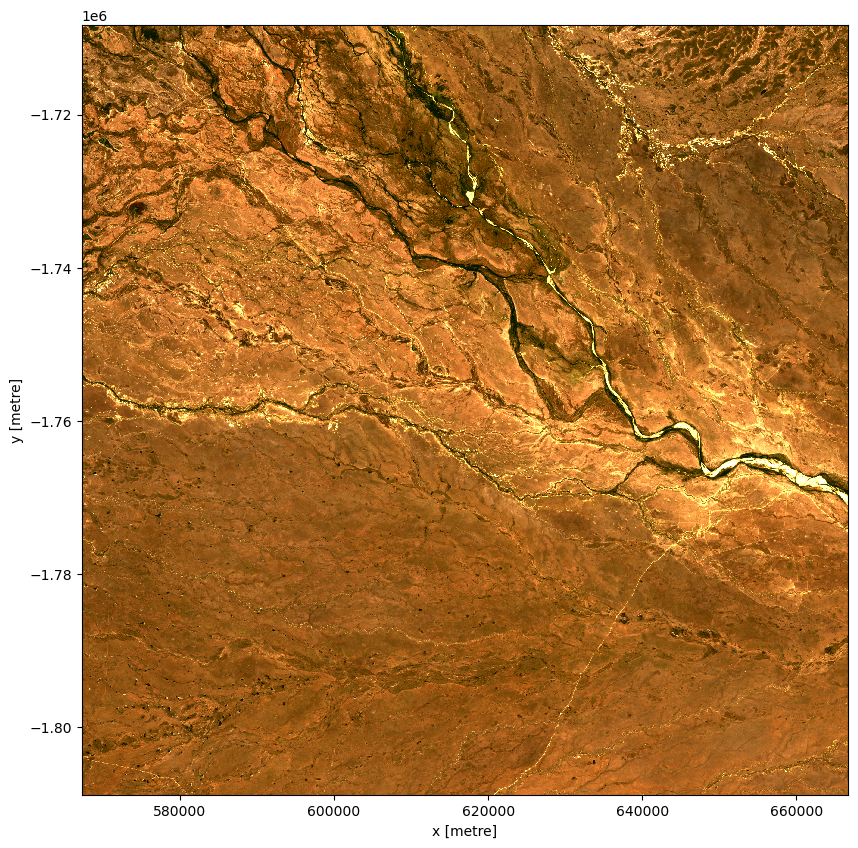

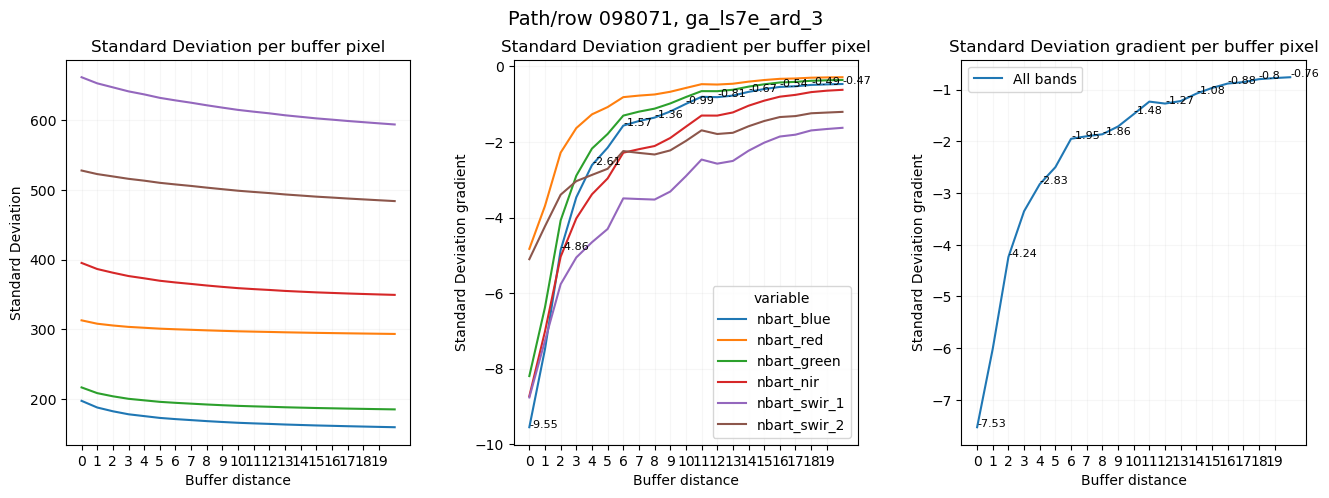

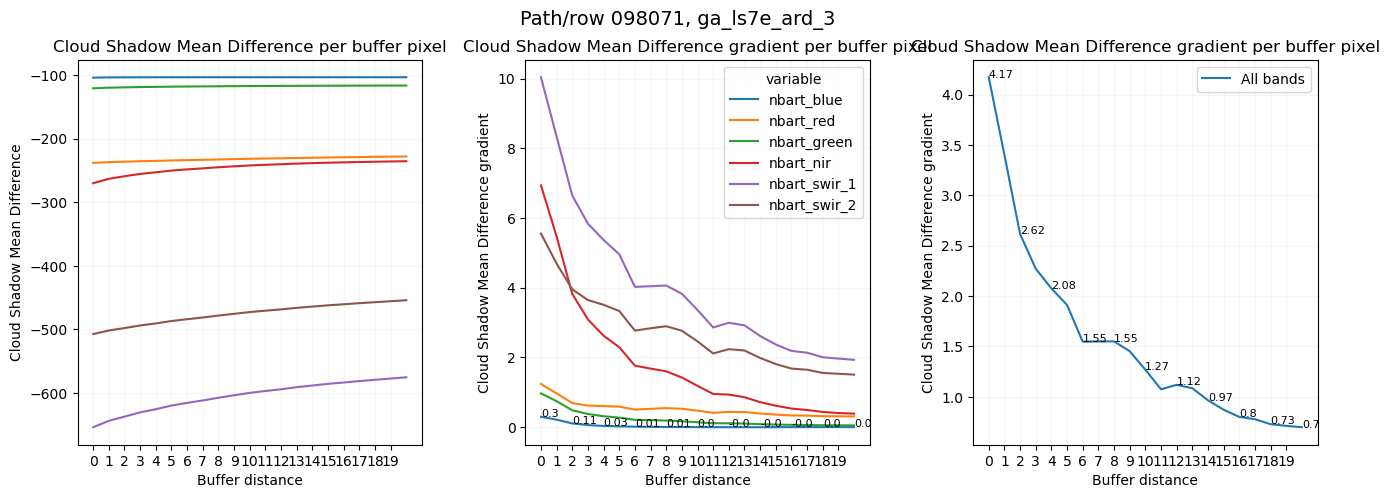

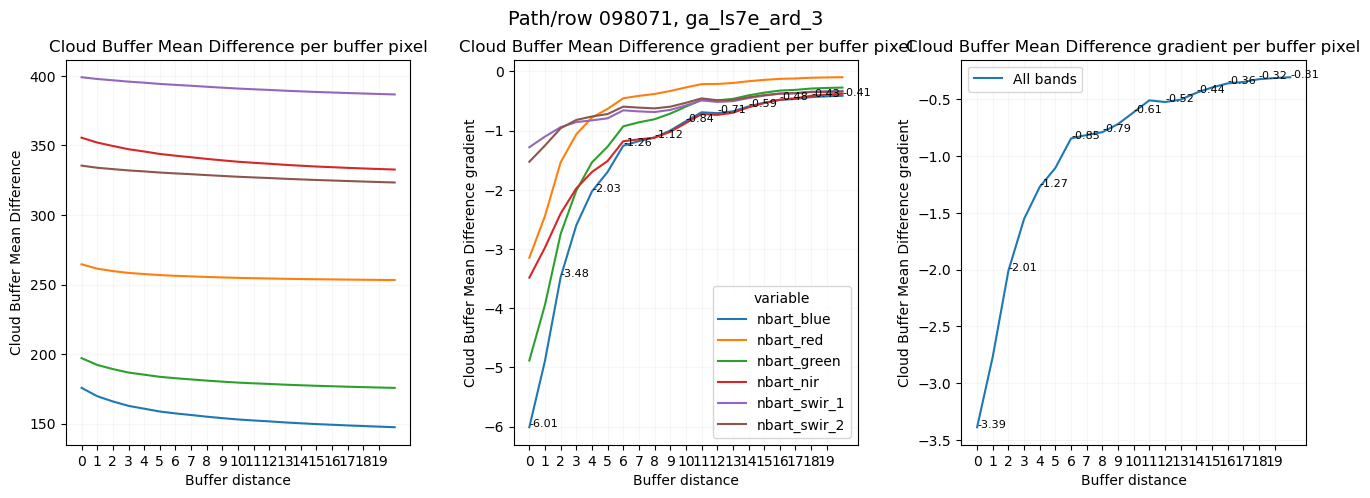

In [13]:
# Create output folder. If it doesn't exist, create it
output_dir = f"output_data/"
os.makedirs(output_dir, exist_ok=True)

for path_row in path_row_list:
    for product in products:
        print(f"Processing path/row {path_row}, product {product}")
        
        # Load path rows, optionally using only a radius around the
        # path-row centroid to reduce processing time and memory use
        query_params = define_query_params(
            path_row, time_period, maturity, radius=50000
        )
        load_params = define_load_params(bands, product, query_params)

        # Small test area
        # query_params = define_query_params_lat_lon_test(time_period)

        # Load data using Dask's .persist() to let us to re-use it each run
        # rather than having to reload for each buffer size
        # for geomedian filter by min good data
        ds_filtered = load_data_geomedian(load_params, product, query_params).persist()

        try:
            print("Calculating geomedian baseline")
            # Calculate a cloud free geomedian baseline
            ds_baseline = apply_geomedian(ds_filtered, geomedian_threads)

            print("Calculating cloud shadow mask")
            # Reload data with no filter and calculate cloud shadow mask
            ds = load_data(load_params, product, query_params).persist()
            cloud_shadow_mask, nodata_mask = calc_cloud_shadow_mask(ds)

            print("Calculating standard deviation and geomedian difference")
            # Calculate standard deviation per buffer in pixels
            std_buffer_df, negative_buffer_df, positive_buffer_df = std_buffer_comp(
                start_buffering, end_buffering, ds, cloud_shadow_mask, nodata_mask, ds_baseline
            )

            # Export results as csv with a "product" and "path_row" column
            std_buffer_df.assign(product=product, path_row=path_row).to_csv(
                f"output_data/{path_row}_{product}_std_buffer.csv", index=True
            )
            negative_buffer_df.assign(product=product, path_row=path_row).to_csv(
                f"output_data/{path_row}_{product}_negative_geomedian_diff_buffer.csv", index=True
            )
            positive_buffer_df.assign(product=product, path_row=path_row).to_csv(
                f"output_data/{path_row}_{product}_positive_geomedian_diff_buffer.csv", index=True
            )

            # Plot the standard deviation and gradient results
            plot_std_gradient_buffer(
                "Standard Deviation",
                std_buffer_df,
                path_row,
                product,
                start_buffering,
                end_buffering,
                export_figure=True,
            )

            plot_std_gradient_buffer(
                "Cloud Shadow Mean Difference",
                negative_buffer_df,
                path_row,
                product,
                start_buffering,
                end_buffering,
                export_figure=True,
            )
            
            plot_std_gradient_buffer(
                "Cloud Buffer Mean Difference",
                positive_buffer_df,
                path_row,
                product,
                start_buffering,
                end_buffering,
                export_figure=True,
            )

        except Exception as e:
            print(f"Error - possibly no data for {product}. {e}")

### Experimental: plotting all tile and product outputs

In [ ]:
import glob
import seaborn as sns

# Identify output CSVs
csvs = glob.glob("output_data/*std_buffer.csv")

# Combine into a singe dataframe
df = pd.concat((pd.read_csv(f) for f in csvs), ignore_index=True)

# Melt into long format for input into seaborn plotting
df_long = df.melt(id_vars=["product", "path_row", "pixel_buffer"], value_name="std")

# Add standard deviation gradient to dataframe
df_long["std_gradient"] = df_long.groupby(["product", "path_row", "variable"])[
    "std"
].transform(np.gradient)

# Take mean of all bands
df_long = df_long.groupby(["product", "path_row", "pixel_buffer"]).mean(
    numeric_only=True
)

In [ ]:
# Plot standard deviation across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std",
    col="product",
    hue="path_row",
    kind="line",
    facet_kws=dict(sharey=False),
)

In [ ]:
# Plot standard deviation across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std",
    col="product",
    kind="line",
    facet_kws=dict(sharey=False),
)

In [ ]:
# Plot standard deviation gradient across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std_gradient",
    hue="path_row",
    col="product",
    kind="line",
)

In [ ]:
# Plot standard deviation gradient across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std_gradient",
    col="product",
    kind="line",
)

2023-07-10 02:52:40,762 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/env/lib/python3.8/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/env/lib/python3.8/asyncio/base_events.py", line 603, in run_until_complete
    self.run_forever()
  File "/env/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/env/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/env/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 192, in _handle_events
    handler_func(fileobj, events)
  File "/env/lib/python3.8/site-packages/tornado/iostream.py", line 691, in _handle_events
    self._handle_read()
  File "/env/lib/python3.8/site-packages/tornado/iostream.py", line 7

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2023

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)